In [1]:
from collections import Counter
import os
from glob import glob
import numbers


from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns


sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [2]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            #print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_71897/3265254245.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


In [3]:
# Plot an example tree
#Source.from_file('../../../mt-SCITE/mt-SCITE_output/P9855/0.0001/0.0001_map0.gv')

## Clone map

In [4]:
data = [['bulk', 's0', 'P3861_218.clean.dedup_ac.txt', 'ss0'], 
        ['E', 's1', 'P9855_2085_S108_L004_ac.txt', 'ss1'],
        ['A', 's2', 'P9855_2089_S112_L004_ac.txt', 'ss2'],
        ['A', 's3', 'P9855_2090_S113_L004_ac.txt', 'ss3'],
        ['D', 's4', 'P9855_2091_S114_L004_ac.txt', 'ss4'],
        ['E', 's5', 'P9855_2093_S116_L005_ac.txt', 'ss5'],
        ['D', 's6', 'P9855_2096_S119_L005_ac.txt', 'ss6'],
        ['F', 's7', 'P9855_2101_S124_L006_ac.txt', 'ss7'],
        ['F', 's8', 'P9855_2102_S125_L006_ac.txt', 'ss8'],
        ['B', 's9', 'P9855_2104_S127_L006_ac.txt', 'ss9'],
        ['C', 's10', 'P9855_2110_S133_L007_ac.txt', 'ss10'],
        ['C', 's11', 'P9855_2111_S134_L007_ac.txt', 'ss11'],
        ['B', 's12', 'P9855_2112_S135_L007_ac.txt', 'ss12']]

clones_map_raw = pd.DataFrame(data, columns=['clone', 'tree_id', 'cell_id', 'node_name'])

clones_map_raw

,clone,tree_id,cell_id,node_name
0,bulk,s0,P3861_218.clean.dedup_ac.txt,ss0
1,E,s1,P9855_2085_S108_L004_ac.txt,ss1
2,A,s2,P9855_2089_S112_L004_ac.txt,ss2
3,A,s3,P9855_2090_S113_L004_ac.txt,ss3
4,D,s4,P9855_2091_S114_L004_ac.txt,ss4
5,E,s5,P9855_2093_S116_L005_ac.txt,ss5
6,D,s6,P9855_2096_S119_L005_ac.txt,ss6
7,F,s7,P9855_2101_S124_L006_ac.txt,ss7
8,F,s8,P9855_2102_S125_L006_ac.txt,ss8
9,B,s9,P9855_2104_S127_L006_ac.txt,ss9


In [5]:
clones_map_raw.clone.value_counts()

E       2
A       2
D       2
F       2
B       2
C       2
bulk    1
Name: clone, dtype: int64

In [6]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [7]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

E       2
A       2
D       2
F       2
B       2
C       2
bulk    1
Name: clone, dtype: int64

## Load tree and pmat data

In [8]:
scite_input_path = '../../../mt-SCITE/mt-SCITE_output/P9855/stdout/'
scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))
#scite_stdout_filenames

In [9]:
pmat_input_path = '../../data/P9855_matrix_output/'
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
#pmats

In [10]:
# Get experiment IDs
experiments = []
for filename in sorted(scite_stdout_filenames):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 2)[0]
    experiments.append(name)

In [11]:
# Get log likelihood scores
lhood = []
for filename in sorted(scite_stdout_filenames):
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)

In [12]:
# Get n mutations
n_mut = []
for filename in sorted(pmats):
    file = open(filename, "r")
    n = len(file.readlines())
    n_mut.append(n)

In [13]:
error_rates = [f'{0.00005:.5f}', f'{0.00009:.5f}', 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.005, 0.025, 0.03]
#error_rates = [float(i) for i in error_rates]
n_trees = [76, 23, 3, 12, 42, 15, 1, 4, 3, 17, 9, 56, 28, 33, 1, 1]

In [14]:
# Create df
samples = 12
performance = pd.DataFrame(experiments)
performance['lhood'] = lhood
performance['n trees'] = n_trees
performance['n mutations'] = n_mut
performance['lhood'] = performance['lhood'].astype(float)
#tree_data['lhood_mut'] = tree_data['best log score for tree']/tree_data['n mutations']
performance['entries'] = performance['n mutations']*samples
performance['lhood_entries'] = performance['lhood']/performance['entries']
performance = performance.rename(columns={0: 'error_rate'})
performance = performance.set_index('error_rate')
performance

,lhood,n trees,n mutations,entries,lhood_entries
error_rate,,,,,
0.00005,-12184.181663,76,1018,12216,-0.997395
0.00009,-2034.252282,23,239,2868,-0.709293
0.0001,-1662.422077,3,193,2316,-0.717799
0.0002,-389.108193,12,66,792,-0.491298
0.0003,-129.650810,42,41,492,-0.263518
0.0004,-124.117935,15,34,408,-0.304211
0.0005,-114.786594,1,34,408,-0.281340
0.0006,-60.083862,4,30,360,-0.166900
0.0007,-38.863853,3,28,336,-0.115666


In [15]:
error_rates = performance.index.tolist()
n_trees = performance['n trees'].tolist()
error_rates, n_trees

(['0.00005',
  '0.00009',
  '0.0001',
  '0.0002',
  '0.0003',
  '0.0004',
  '0.0005',
  '0.0006',
  '0.0007',
  '0.0008',
  '0.0009',
  '0.001',
  '0.002',
  '0.005',
  '0.025',
  '0.03'],
 [76, 23, 3, 12, 42, 15, 1, 4, 3, 17, 9, 56, 28, 33, 1, 1])

In [107]:
MAX_TREES_PER_ERROR_RATE = 100

all_trees = {}
for error_rate, n in zip(error_rates, n_trees):
    all_trees[error_rate] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        tree_filename = f'../../../mt-SCITE/mt-SCITE_output/P9855/all_dot_files/{error_rate}_map{idx}.gv'
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        tree.remove_node('\\n')
        all_trees[error_rate].append(tree)

In [108]:
#all_trees

In [109]:
performance['tree_size'] = 0
for error_rate, trees in all_trees.items():
    n_nodes = [t.number_of_nodes() for t in trees]
    performance.loc[error_rate, 'tree_size'] = np.mean(n_nodes)

In [110]:
#performance

In [111]:
#t = all_trees['0.0001'][0]

In [112]:
#clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
#clones_count

In [113]:
#p = purity(clones_count)
#p = p[[c for c in p.columns if c not in clones_map.keys()]]
#p

# Avg purity of nodes with >1 sample

In [128]:
import warnings
warnings.filterwarnings('ignore')

performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    #n_purities_100 = []
    for t in trees:
        #print(error_rate, get_root_node(t))
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        #print(p)
        
        # exclude mutations shared by all clones
        p = p.T
        p = p.mask((p.A > 0) & (p.B > 0) & (p.C > 0) & (p.D > 0) & (p.E > 0) & (p.F > 0))
        p = p.dropna().T
        
        
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        #print(avg_purities)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

In [129]:
performance

,lhood,n trees,n mutations,entries,lhood_entries,tree_size,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample,min_clone_coverage,avg_clone_coverage
error_rate,,,,,,,,,,
0.00005,-12184.181663,76,1018,12216,-0.997395,1032,0.546476,0.125714,0.5,0.583333
0.00009,-2034.252282,23,239,2868,-0.709293,253,0.806597,0.675000,0.5,0.833333
0.0001,-1662.422077,3,193,2316,-0.717799,207,0.827903,0.644737,0.5,0.833333
0.0002,-389.108193,12,66,792,-0.491298,80,0.908772,0.842105,0.5,0.916667
0.0003,-129.650810,42,41,492,-0.263518,55,0.916667,0.857143,0.5,0.916667
0.0004,-124.117935,15,34,408,-0.304211,48,0.929792,0.884615,0.5,0.916667
0.0005,-114.786594,1,34,408,-0.281340,48,0.942667,0.880000,0.5,0.916667
0.0006,-60.083862,4,30,360,-0.166900,44,0.959420,0.913043,0.5,0.916667
0.0007,-38.863853,3,28,336,-0.115666,42,0.984848,0.954545,0.5,0.916667


# Clone coverage at full purity

In [130]:
performance['min_clone_coverage'] = np.nan
performance['avg_clone_coverage'] = np.nan
for error_rate, trees in all_trees.items():
    t = trees[0]

    clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
    p = purity(clones_count)
    is_pure = p.max(axis=0) == 1.0
    coverage_per_clone = clones_count.loc[:, is_pure].div(n_samples_per_clone, axis=0).max(axis=1)
    print(error_rate, '\n', coverage_per_clone, '\n---')
    min_coverage = coverage_per_clone.min()
    avg_coverage = coverage_per_clone.drop('bulk').mean()
    performance.loc[error_rate, 'min_clone_coverage'] = min_coverage
    performance.loc[error_rate, 'avg_clone_coverage'] = avg_coverage

0.00005 
 A       1.0
B       0.5
C       0.5
D       0.5
E       0.5
F       0.5
bulk    1.0
dtype: float64 
---
0.00009 
 A       1.0
B       1.0
C       0.5
D       1.0
E       0.5
F       1.0
bulk    1.0
dtype: float64 
---
0.0001 
 A       1.0
B       1.0
C       0.5
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0002 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0003 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0004 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0005 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0006 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0007 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
d

# Pure nodes per clone

In [135]:
warnings.filterwarnings('ignore')

data = [0, 1, 2, 3, 4, 5, 6]
index = ['bulk', 'A', 'B', 'C', 'D', 'E', 'F']
df = pd.DataFrame(data, columns=['Numbers'])
df = df.set_index('Numbers')


for error_rate, trees in all_trees.items():

    for t in trees:
        error_rate = error_rate
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        purities = p.T.apply(pd.value_counts).fillna(0) # order is changed here
        pure_nodes = purities.iloc[-1]
        pure_nodes = pure_nodes.reset_index()
        pure_nodes.columns = ['clone', str(error_rate)]
        df = pd.concat([df, pure_nodes], axis=1)

index = df.iloc[:, 0].tolist()
df.index = index

# remove duplicate clone columns 
df = df.drop(df.filter(regex='clone').columns, axis=1)

# get mean of columns with the same name
# https://stackoverflow.com/questions/40311987/pandas-mean-of-columns-with-the-same-names
n_purities = df.groupby(by=df.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


# get error rates with an average purity > 90%
good_error_rates = performance.query('avg_purity_more_than_one_sample > 0.9').index.to_list()


# get only these columns
n_purities_good_error_rates = n_purities[good_error_rates]

# get the average number of mutations per clone
n_purities_good_error_rates['mean_pure_nodes_clone'] = n_purities_good_error_rates.mean(axis=1)

# remove bulk
n_purities_good_error_rates = n_purities_good_error_rates.iloc[1: , :]

# Average number of clone specific mutations
n_purities_good_error_rates["mean_pure_nodes_clone"].mean()


3.5151515151515156

In [136]:
n_purities_good_error_rates

,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002,0.005,mean_pure_nodes_clone
E,7.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.818182
A,10.0,9.0,8.0,8.0,7.0,7.0,6.0,5.0,5.0,5.0,4.0,6.727273
D,9.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.636364
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
B,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.909091
C,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000


In [133]:
# Prepare df for plotting
hej = n_purities_good_error_rates.copy()

hej = hej.drop('mean_pure_nodes_clone', axis=1)
hej = hej.T

# order axis
hej = hej.reindex(sorted(hej.columns), axis=1)
hej

,A,B,C,D,E,F
0.00009,17.0,8.0,0.0,23.0,0.0,6.0
0.0001,17.0,6.0,0.0,13.0,13.0,0.0
0.0002,10.0,4.0,2.0,9.0,7.0,0.0
0.0003,9.0,4.0,2.0,3.0,6.0,0.0
0.0004,8.0,5.0,2.0,3.0,5.0,0.0
0.0005,8.0,4.0,2.0,3.0,5.0,0.0
0.0006,7.0,4.0,2.0,3.0,5.0,0.0
0.0007,7.0,4.0,2.0,3.0,5.0,0.0
0.0008,6.0,4.0,2.0,3.0,5.0,0.0
0.0009,5.0,4.0,2.0,3.0,4.0,0.0


# Plots

In [24]:
performance

,lhood,n trees,n mutations,entries,lhood_entries,tree_size,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample,min_clone_coverage,avg_clone_coverage
error_rate,,,,,,,,,,
0.00005,-12184.181663,76,1018,12216,-0.997395,1032,0.477845,0.102326,0.5,0.583333
0.00009,-2034.252282,23,239,2868,-0.709293,253,0.679240,0.540000,0.5,0.833333
0.0001,-1662.422077,3,193,2316,-0.717799,207,0.695680,0.515789,0.5,0.833333
0.0002,-389.108193,12,66,792,-0.491298,80,0.753900,0.666667,0.5,0.916667
0.0003,-129.650810,42,41,492,-0.263518,55,0.749644,0.666667,0.5,0.916667
0.0004,-124.117935,15,34,408,-0.304211,48,0.767988,0.696970,0.5,0.916667
0.0005,-114.786594,1,34,408,-0.281340,48,0.792060,0.709677,0.5,0.916667
0.0006,-60.083862,4,30,360,-0.166900,44,0.794960,0.724138,0.5,0.916667
0.0007,-38.863853,3,28,336,-0.115666,42,0.809066,0.750000,0.5,0.916667


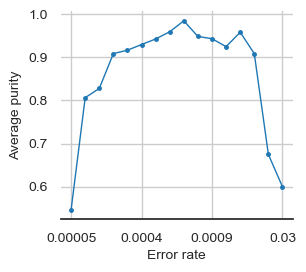

In [138]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.avg_purity_more_than_one_sample.plot(marker='o', markersize=2.5, lw=1)    
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Average purity')
    plt.savefig('../../data/P9855_figures/avg_purity.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/P9855_figures/avg_purity.jpg', dpi=300, bbox_inches='tight', transparent=True)

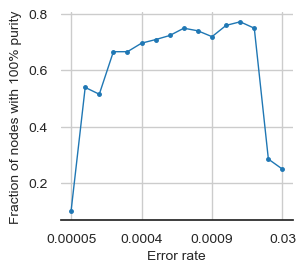

In [48]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.frac_purity_100_more_than_one_sample.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Fraction of nodes with 100% purity')
    plt.savefig('../../data/P9855_figures/frac_pure_nodes.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/P9855_figures/frac_pure_nodes.jpg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.xscale('log')

In [51]:
# Does not make sense to have this for clones with only two samples?

#with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
#    performance.avg_clone_coverage.plot(marker='o', markersize=2.5, lw=1)
#    plt.grid(axis='both')
#    plt.xlabel('Error rate')
#    plt.ylabel('Avg clone coverage at 100% purity')
#    #plt.xscale('log')
#    plt.ylim(0, 1)

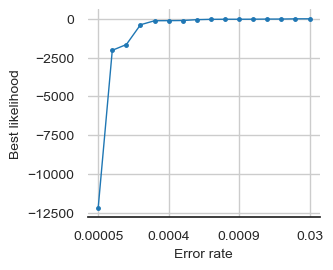

In [54]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.lhood.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Best likelihood')
    plt.savefig('../../data/P9855_figures/best_likelihood.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/P9855_figures/best_likelihood.jpg', dpi=300, bbox_inches='tight', transparent=True)

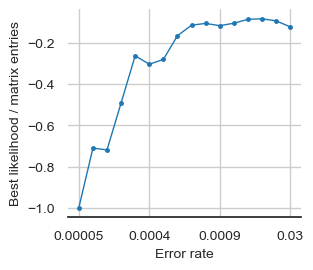

In [55]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.lhood_entries.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Best likelihood / matrix entries')
    plt.savefig('../../data/P9855_figures/likelihood_entries.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/P9855_figures/likelihood_entries.jpg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.savefig('../../data/P9855_figures/P9855_lhood_entries.svg', dpi=300, bbox_inches='tight', transparent=True)

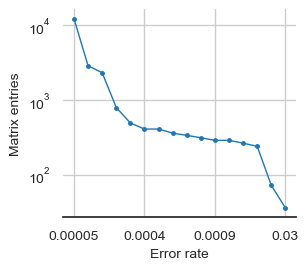

In [56]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.entries.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    plt.yscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Matrix entries')
    plt.savefig('../../data/P9855_figures/entries.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/P9855_figures/entries.jpg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.savefig('figs/performance/train_atac_log_lhood.png', dpi=300)

In [63]:
performance.rename(columns = {'n trees':'n_trees'}, inplace = True)
performance

,lhood,n_trees,n mutations,entries,lhood_entries,tree_size,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample,min_clone_coverage,avg_clone_coverage
error_rate,,,,,,,,,,
0.00005,-12184.181663,76,1018,12216,-0.997395,1032,0.477845,0.102326,0.5,0.583333
0.00009,-2034.252282,23,239,2868,-0.709293,253,0.679240,0.540000,0.5,0.833333
0.0001,-1662.422077,3,193,2316,-0.717799,207,0.695680,0.515789,0.5,0.833333
0.0002,-389.108193,12,66,792,-0.491298,80,0.753900,0.666667,0.5,0.916667
0.0003,-129.650810,42,41,492,-0.263518,55,0.749644,0.666667,0.5,0.916667
0.0004,-124.117935,15,34,408,-0.304211,48,0.767988,0.696970,0.5,0.916667
0.0005,-114.786594,1,34,408,-0.281340,48,0.792060,0.709677,0.5,0.916667
0.0006,-60.083862,4,30,360,-0.166900,44,0.794960,0.724138,0.5,0.916667
0.0007,-38.863853,3,28,336,-0.115666,42,0.809066,0.750000,0.5,0.916667


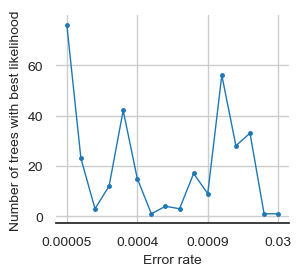

In [67]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.n_trees.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    #plt.yscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Number of trees with best likelihood')
    plt.savefig('../../data/P9855_figures/n_trees.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/P9855_figures/n_trees.jpg', dpi=300, bbox_inches='tight', transparent=True)


In [62]:
performance['n trees']

performance.rename(columns = {'n trees':'n_trees'}, inplace = True)

error_rate
0.00005    76
0.00009    23
0.0001      3
0.0002     12
0.0003     42
0.0004     15
0.0005      1
0.0006      4
0.0007      3
0.0008     17
0.0009      9
0.001      56
0.002      28
0.005      33
0.025       1
0.03        1
Name: n trees, dtype: int64

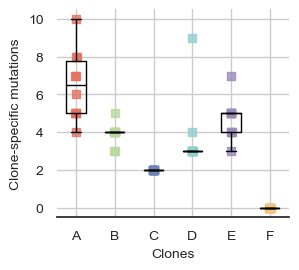

In [127]:
# Clone specific mutations

with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Clones')
    plt.ylabel('Clone-specific mutations')

    vals, names, xs = [],[],[]
    for i, col in enumerate(hej.columns):
        vals.append(hej[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.01, hej[col].values.shape[0]))  # adds jitter to the data points
    #print(names)

    boxplot = plt.boxplot(vals, labels=names, showfliers=False)# patch_artist=True)
    palette = ['#E5715F', '#BAD99F', '#6C85B6', '#91CFCF', '#978CB7', '#F2C381']
    
    for median in boxplot['medians']:
        median.set_color('black')
    for x, val, c in zip(xs, vals, palette):
        plt.scatter(x, val, alpha=0.8, color=c, marker='s', s=40)  
        
    plt.savefig('../../data/P9855_figures/n_clone_muts.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/P9855_figures/n_clone_muts.jpg', dpi=300, bbox_inches='tight', transparent=True)